In [329]:
# MODEL PARAMETERS

# Adjust model params here
event_length = 5 
baseline_beta = 1
mitigation_beta = 1
prevalence = .1
pop = 1000

# Booleans for choice of intervention
use_vaccines = True
use_testing = False
use_base_beta = False
use_mit_beta = False

# Testing params
test_del = 0 # Test delay
days_testing = 0 # Number of days performing tests susceptibles
subtarg = None # Subtargetting of tests
sens = .95 # Sensitivity of test used

# Vaccine params
perc_vax = .2 # Percentage of population vaxxed
passport = True # True if 100% of attendees must be vaccinated


In [330]:
# IMPORTS
import covasim as cv
from datetime import date, timedelta

In [331]:
## Date Extraction
today = date.today()

# Function to format date into proper string
def format_day(date):
    return date.strftime("%Y-%m-%d")

In [332]:

# For time to death, should we just make it kill immediately by adjusting exp2inf and crit2die? Or add 30 days to simulation?

# Get start and end date of event, starting today
d1 = format_day(today)
d2 = format_day(today + timedelta(days = event_length))

# Initialize model parameters
pars = dict(
    start_day = d1,
    end_day   = d2,
    pop_type  = 'hybrid',
    pop_size = pop,
    pop_infected = pop * prevalence
)

""" test_intervention: Creates intervention for a testing strategy
-   test_del: Delay in test result
-   days_testing: Number of days in event testing susceptibles
-   subtarg: Indices of population to subtarget
-   sens: Sensitivity of test used
"""
# Note: this only works for cases generated at event. 
# For single entry testing only, run test_intervention(0,0)
def test_intervention(test_del, days_testing, subtarg=None, sens=1):

    #Todo: Add probability to sensitivity
    pars['pop_infected'] -= sens * pars['pop_infected']

    return cv.test_num(daily_tests=[pop]*days_testing, 
                       start_day=d1, 
                       subtarget=subtarg,
                       symp_test=0,
                       sensitivity=sens,
                       test_delay=test_del)

"""vaccine_intervention: Creates intervention for a vaccine-based entry strategy
- percent_vax: Percentage of overall population vaccinated
- passport: If true, 100% of attendees must be vaccinated
- Returns intervention 
"""
def vaccine_intervention(percent_vax, passport = False):
    if passport:
        percent_vax = 1
    return cv.vaccine(days=0, prob=percent_vax, rel_sus=.2, rel_symp=.2)





In [333]:
# INTERVENTIONS AND SIMULATIONS

# Shared interventions
end_of_event = cv.change_beta(days=[d2], changes=[0]) # Transmission stops after event ends

# Baseline interventions and simulation
base_interventions = [end_of_event]

if (use_base_beta):
    event_baseline = cv.dynamic_pars(beta=dict(days=list(range(event_length)), vals=[baseline_beta]*(event_length)))
    base_interventions.append(event_baseline)

orig_sim = cv.Sim(pars, interventions=base_interventions, label='Baseline')

# Mitigation interventions and simulation
mit_interventions = [end_of_event]
if (use_testing):
    test_int = test_intervention(test_del=test_del, days_testing=days_testing, sens=sens)
    mit_interventions.append(test_int)
if (use_vaccines):
    vc = vaccine_intervention(perc_vax, passport)
    mit_interventions.append(vc)
if (use_mit_beta):
    event_mitigate = cv.dynamic_pars(beta=dict(days=list(range(event_length)), vals=[mitigation_beta]*(event_length)))
    mit_interventions.append(event_mitigate)

sim = cv.Sim(pars, interventions=mit_interventions, label='With mitigation measures')

Initializing sim with 1000 people for 5 days
Initializing sim with 1000 people for 5 days
  Running "Baseline": 2021-04-03 ( 0/5) (0.13 s)  •••————————————————— 17%
  Running "With mitigation measures": 2021-04-03 ( 0/5) (0.15 s)  •••————————————————— 17%
Simulation "Baseline" summary:
     151 cumulative infections
      77 cumulative infectious
       0 cumulative tests
       0 cumulative diagnoses
       0 cumulative recoveries
      37 cumulative symptomatic cases
       0 cumulative severe cases
       0 cumulative critical cases
       0 cumulative deaths
       0 cumulative quarantined people

Simulation "With mitigation measures" summary:
     107 cumulative infections
      76 cumulative infectious
       0 cumulative tests
       0 cumulative diagnoses
       0 cumulative recoveries
      37 cumulative symptomatic cases
       0 cumulative severe cases
       0 cumulative critical cases
       0 cumulative deaths
       0 cumulative quarantined people



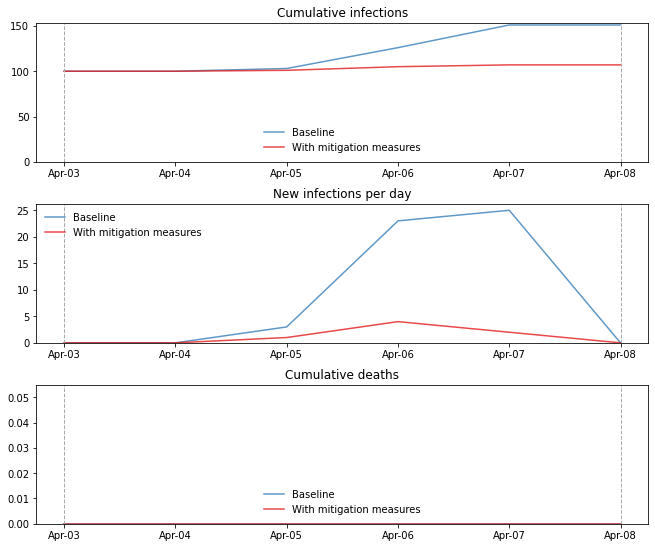

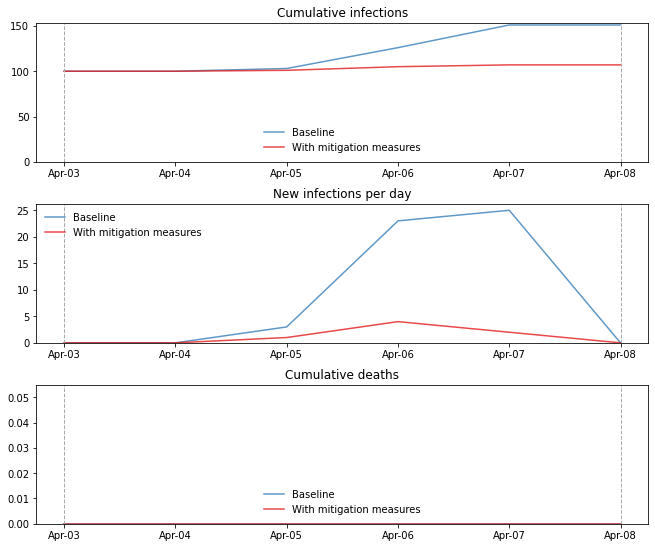

In [334]:
# RUN AND PLOT
msim = cv.MultiSim([orig_sim, sim])
msim.run()
msim.plot()